# **실제 배송 도착일 예측 모델**

**접근 : Regression(XGBoost, LightGBM, Random Forest)**

**예측 정확도 개선을 핵심 성과로 제시.**

In [156]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [157]:
import pandas as pd
import numpy as np

In [158]:
# 데이터 불러오기
customers = pd.read_csv('/content/drive/MyDrive/miniproject/Brazilian E-Commerce Public Dataset by Olist/customers.csv')
sellers = pd.read_csv('/content/drive/MyDrive/miniproject/Brazilian E-Commerce Public Dataset by Olist/sellers.csv')
order_items = pd.read_csv('/content/drive/MyDrive/miniproject/Brazilian E-Commerce Public Dataset by Olist/order_items.csv')
products = pd.read_csv('/content/drive/MyDrive/miniproject/Brazilian E-Commerce Public Dataset by Olist/products.csv')
orders=pd.read_csv('/content/drive/MyDrive/miniproject/Brazilian E-Commerce Public Dataset by Olist/olist_orders_dataset.csv')

## **기초통계 확인**

In [159]:
customers.info() #위도, 경도 결측치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         99441 non-null  object 
 1   customer_unique_id  99441 non-null  object 
 2   zip_code_prefix     99441 non-null  int64  
 3   city                99441 non-null  object 
 4   state               99441 non-null  object 
 5   lat                 99163 non-null  float64
 6   lng                 99163 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 5.3+ MB


In [160]:
sellers.info() #위도, 경도 결측치

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   seller_id        3095 non-null   object 
 1   zip_code_prefix  3095 non-null   int64  
 2   city             3095 non-null   object 
 3   state            3095 non-null   object 
 4   lat              3088 non-null   float64
 5   lng              3088 non-null   float64
dtypes: float64(2), int64(1), object(3)
memory usage: 145.2+ KB


In [161]:
order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   product_id           112650 non-null  object 
 2   seller_id            112650 non-null  object 
 3   shipping_limit_date  112650 non-null  object 
 4   price                112650 non-null  float64
 5   freight_value        112650 non-null  float64
dtypes: float64(2), object(4)
memory usage: 5.2+ MB


In [162]:
order_items.describe()

,price,freight_value
count,112650.000000,112650.000000
mean,120.653739,19.990320
std,183.633928,15.806405
min,0.850000,0.000000
25%,39.900000,13.080000
50%,74.990000,16.260000
75%,134.900000,21.150000
max,6735.000000,409.680000


In [163]:
products.info() #결측치 처리 필요

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             32951 non-null  object 
 1   product_weight_g       32949 non-null  float64
 2   product_length_cm      32949 non-null  float64
 3   product_height_cm      32949 non-null  float64
 4   product_width_cm       32949 non-null  float64
 5   product_category_name  32328 non-null  object 
dtypes: float64(4), object(2)
memory usage: 1.5+ MB


In [164]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


**결측치 처리 필요**

## **데이터 합치기**

In [165]:
final=order_items.merge(products,on='product_id',how='left')
final=final.merge(orders,on='order_id',how='left')
final=final.merge(customers,on='customer_id',how='left')

final=final.rename(columns={'lat':'customer_lat','lng':'customer_lng'})

final=final.merge(sellers,on='seller_id',how='left')

final=final.rename(columns={'lat':'seller_lat','lng':'seller_lng'})
final.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,zip_code_prefix_x,city_x,state_x,customer_lat,customer_lng,zip_code_prefix_y,city_y,state_y,seller_lat,seller_lng
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,650.0,28.0,9.0,14.0,...,28013,campos dos goytacazes,RJ,-21.762829,-41.310605,27277,volta redonda,SP,-22.498419,-44.125272
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,30000.0,50.0,30.0,40.0,...,15775,santa fe do sul,SP,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,3050.0,33.0,13.0,33.0,...,35661,para de minas,MG,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,200.0,16.0,10.0,15.0,...,12952,atibaia,SP,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,3750.0,35.0,40.0,30.0,...,13226,varzea paulista,SP,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438


In [166]:
#from google.colab import files
#final.to_csv("data.csv", index=False)
#files.download("data.csv")

In [167]:
final.shape

(112650, 29)

## **전처리**

### **1. product변수 결측치 처리. 부피 변수로 변환 전 이상치는 없는지 확인하기**

In [168]:
# 결측치 개수 확인
print(products.isnull().sum())

product_id                 0
product_weight_g           2
product_length_cm          2
product_height_cm          2
product_width_cm           2
product_category_name    623
dtype: int64


In [169]:
# product_category_name NaN → 'others'로 대체
final['product_category_name'] = final['product_category_name'].fillna('others')

In [170]:
# product_category_name 제외하고 결측치가 있는 행 추출
cols_to_check = ['product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']

missing_numeric_rows = products[products[cols_to_check].isnull().any(axis=1)]
missing_numeric_rows

,product_id,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name
8578,09ff539a621711667c43eba6a3bd8466,NaN,NaN,NaN,NaN,baby
18851,5eb564652db742ff8f28759cd8d2652a,NaN,NaN,NaN,NaN,NaN


In [171]:
# product_weight_g NaN 제거
final = final.dropna(subset=['product_weight_g'])

In [172]:
products.describe()

,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,32949.000000,32949.000000,32949.000000,32949.000000
mean,2276.472488,30.815078,16.937661,23.196728
std,4282.038731,16.914458,13.637554,12.079047
min,0.000000,7.000000,2.000000,6.000000
25%,300.000000,18.000000,8.000000,15.000000
50%,700.000000,25.000000,13.000000,20.000000
75%,1900.000000,38.000000,21.000000,30.000000
max,40425.000000,105.000000,105.000000,118.000000


In [173]:
#무게 0인 것
not_equal=final[final['product_weight_g'] == 0]
not_equal

not_equal['product_category_name'].value_counts()

,count
product_category_name,
bed_bath_table,8


In [174]:
#무게 0 삭제
final = final[final["product_weight_g"] != 0]

### **2. 위도 경도 결측치 city 중앙값, state 중앙값으로 묶기**

In [175]:
missing_rows = customers[customers.isnull().any(axis=1)]

# 결측치 개수 확인
print(customers.isnull().sum())

customer_id             0
customer_unique_id      0
zip_code_prefix         0
city                    0
state                   0
lat                   278
lng                   278
dtype: int64


**우편번호가 geolocation 데이터셋에 없는 것들은 NaN처리 됨**

In [176]:
missing_rows = sellers[sellers.isnull().any(axis=1)]
print(missing_rows)

# 결측치 개수 확인
print(sellers.isnull().sum())

                             seller_id  zip_code_prefix             city  \
473   5962468f885ea01a1b6a97a218797b0a            82040         curitiba   
791   2aafae69bf4c41fbd94053d9413e87ee            91901     porto alegre   
1672  2a50b7ee5aebecc6fd0ff9784a4747d6            72580         brasilia   
1931  2e90cb1677d35cfe24eef47d441b7c87             2285        sao paulo   
2182  0b3f27369a4d8df98f7eb91077e438ac             7412            aruja   
2986  42bde9fef835393bb8a8849cb6b7f245            71551         brasilia   
3028  870d0118f7a9d85960f29ad89d5d989a            37708  pocos de caldas   

     state  lat  lng  
473     PR  NaN  NaN  
791     RS  NaN  NaN  
1672    DF  NaN  NaN  
1931    SP  NaN  NaN  
2182    SP  NaN  NaN  
2986    DF  NaN  NaN  
3028    MG  NaN  NaN  
seller_id          0
zip_code_prefix    0
city               0
state              0
lat                7
lng                7
dtype: int64


In [177]:
# customer_lat, customer_lng NaN → 해당 city_x의 중앙값으로 채우기
final['customer_lat'] = final.groupby('city_x')['customer_lat'].transform(lambda x: x.fillna(x.median()))
final['customer_lng'] = final.groupby('city_x')['customer_lng'].transform(lambda x: x.fillna(x.median()))

In [178]:
# sellerr_lat, seller_lng NaN → 해당 city_y의 중앙값으로 채우기
final['seller_lat'] = final.groupby('city_y')['seller_lat'].transform(lambda x: x.fillna(x.median()))
final['seller_lng'] = final.groupby('city_y')['seller_lng'].transform(lambda x: x.fillna(x.median()))

In [179]:
# customer_lat, customer_lng NaN → 해당 state_x의 중앙값으로 채우기
final['customer_lat'] = final.groupby('state_x')['customer_lat'].transform(lambda x: x.fillna(x.median()))
final['customer_lng'] = final.groupby('state_x')['customer_lng'].transform(lambda x: x.fillna(x.median()))

In [180]:
# order_status == delivered 만 남기기
# 배송완료인 데이터만 추출
final = final[final['order_status'] == 'delivered']

In [181]:
# 결측치 개수 확인
print(final.isnull().sum())

order_id                          0
product_id                        0
seller_id                         0
shipping_limit_date               0
price                             0
freight_value                     0
product_weight_g                  0
product_length_cm                 0
product_height_cm                 0
product_width_cm                  0
product_category_name             0
customer_id                       0
order_status                      0
order_purchase_timestamp          0
order_approved_at                15
order_delivered_carrier_date      2
order_delivered_customer_date     8
order_estimated_delivery_date     0
customer_unique_id                0
zip_code_prefix_x                 0
city_x                            0
state_x                           0
customer_lat                      0
customer_lng                      0
zip_code_prefix_y                 0
city_y                            0
state_y                           0
seller_lat                  

In [182]:
#배송상태가 완료인 것 중 배송완료시각 값이 없는 것 삭제
final = final.dropna(subset=['order_delivered_customer_date'])

### **3. 부피 변수 생성**

In [183]:
final['product_volume_cm3'] = final['product_length_cm'] * final['product_width_cm'] * final['product_height_cm']

### **4. 거리 변수 생성**

속도가 더 느리지만 정확도가 더 높은 geodesic 사용

In [184]:
from geopy.distance import geodesic

# 거리 계산 함수 정의
def calc_distance(row):
    customer_loc = (row['customer_lat'], row['customer_lng'])
    seller_loc = (row['seller_lat'], row['seller_lng'])
    return geodesic(customer_loc, seller_loc).km   # km 단위로 반환

final['distance_km'] = final.apply(calc_distance, axis=1)

### **5. 소요일 수 변수 생성**

In [185]:
# datetime으로 변환
final['order_delivered_customer_date'] = pd.to_datetime(final['order_delivered_customer_date'])
final['order_purchase_timestamp'] = pd.to_datetime(final['order_purchase_timestamp'])

# 소요일 계산 (일 단위)
final['shipping_days'] = (final['order_delivered_customer_date'] - final['order_purchase_timestamp']).dt.days

In [186]:
final.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_lat,customer_lng,zip_code_prefix_y,city_y,state_y,seller_lat,seller_lng,product_volume_cm3,distance_km,shipping_days
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,650.0,28.0,9.0,14.0,...,-21.762829,-41.310605,27277,volta redonda,SP,-22.498419,-44.125272,3528.0,301.582449,7
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,30000.0,50.0,30.0,40.0,...,-20.205737,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,60000.0,587.970634,16
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,3050.0,33.0,13.0,33.0,...,-19.870383,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,14157.0,311.990753,7
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,200.0,16.0,10.0,15.0,...,-23.104346,-46.595589,14403,franca,SP,-20.554951,-47.387691,2400.0,293.925230,6
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,3750.0,35.0,40.0,30.0,...,-23.245512,-46.825182,87900,loanda,PR,-22.930408,-53.136438,42000.0,647.515365,25


### **6. 배송 거리가 0인 데이터**

In [187]:
not_equal=final[final['distance_km'] == 0]

In [188]:
#거리가 0인 것은 모두 우편번호가 같음
not_equal_filtered = not_equal[not_equal["zip_code_prefix_x"] != not_equal["zip_code_prefix_y"]]
not_equal_filtered

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_lat,customer_lng,zip_code_prefix_y,city_y,state_y,seller_lat,seller_lng,product_volume_cm3,distance_km,shipping_days


**우편번호 앞자리가 같아서 거리가 같게 0으로 출력되기도 함. 아예 거리가 같을 리가 없으므로 임의로 0.001로 변환 **

In [189]:
final["distance_km"] = final["distance_km"].replace(0, 0.001)

### **7. state 동일 여부**

In [190]:
# 같은 경우 / 다른 경우 개수 세기
counts = (final['state_x'] == final['state_y']).value_counts()

print("state_x == state_y:", counts.get(True, 0))
print("state_x != state_y:", counts.get(False, 0))

state_x == state_y: 39856
state_x != state_y: 70307


In [191]:
final['state_equal'] = np.where(final['state_x'] == final['state_y'], 1, 0)

final.head()

,order_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_weight_g,product_length_cm,product_height_cm,product_width_cm,...,customer_lng,zip_code_prefix_y,city_y,state_y,seller_lat,seller_lng,product_volume_cm3,distance_km,shipping_days,state_equal
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,650.0,28.0,9.0,14.0,...,-41.310605,27277,volta redonda,SP,-22.498419,-44.125272,3528.0,301.582449,7,0
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,30000.0,50.0,30.0,40.0,...,-50.926924,3471,sao paulo,SP,-23.564289,-46.519045,60000.0,587.970634,16,1
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,3050.0,33.0,13.0,33.0,...,-44.594355,37564,borda da mata,MG,-22.271648,-46.165556,14157.0,311.990753,7,1
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,200.0,16.0,10.0,15.0,...,-46.595589,14403,franca,SP,-20.554951,-47.387691,2400.0,293.925230,6,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,3750.0,35.0,40.0,30.0,...,-46.825182,87900,loanda,PR,-22.930408,-53.136438,42000.0,647.515365,25,0


### **8. 예상 소요일 수 변수 생성**

In [192]:
# datetime으로 변환
final['order_estimated_delivery_date'] = pd.to_datetime(final['order_estimated_delivery_date'])
final['order_delivered_customer_date'] = pd.to_datetime(final['order_delivered_customer_date'])

# 소요일 계산 (일 단위)
final['dif_days'] = (final['order_estimated_delivery_date'] - final['order_delivered_customer_date']).dt.days

### **9. 필요없는 변수 삭제**

In [193]:
final_clean = final.drop(columns=[
    'order_id', 'product_id', 'seller_id', 'customer_id', 'customer_unique_id',
     'product_length_cm','product_height_cm','product_width_cm',
    'order_status', 'shipping_limit_date','order_approved_at',
    'zip_code_prefix_x','city_x', 'state_x', 'customer_lat', 'customer_lng',
    'zip_code_prefix_y','city_y', 'state_y', 'seller_lat', 'seller_lng'
], errors='ignore')

### **10. 배송 단가 변수 생성**

In [194]:
# 배송 단가
final_clean['shipping_cost_per_km'] = final_clean['freight_value'] / final_clean['distance_km']

final_clean.head()

,price,freight_value,product_weight_g,product_category_name,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km
0,58.90,13.29,650.0,cool_stuff,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,0,8,0.044068
1,239.90,19.93,30000.0,pet_shop,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,1,2,0.033896
2,199.00,17.87,3050.0,furniture_decor,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,1,13,0.057277
3,12.99,12.79,200.0,perfumery,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,1,5,0.043514
4,199.90,18.14,3750.0,garden_tools,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,0,15,0.028015


In [195]:
final_clean.describe().round(3)

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km
count,110163.000,110163.000,110163.000,110163,110163,110163,110163.000,110163.000,110163.000,110163.000,110163.000,110163.000
mean,119.975,19.949,2089.840,2018-01-02 03:13:10.449034496,2018-01-14 14:33:17.051859456,2018-01-25 22:29:31.912529920,15173.467,595.741,12.007,0.362,11.028,4.384
min,0.850,0.000,2.000,2016-09-15 12:16:38,2016-10-11 13:46:32,2016-10-04 00:00:00,168.000,0.001,0.000,0.000,-189.000,0.000
25%,39.900,13.080,300.000,2017-09-15 09:16:01,2017-09-26 20:33:15,2017-10-06 00:00:00,2850.000,185.872,6.000,0.000,6.000,0.024
50%,74.900,16.260,700.000,2018-01-21 10:16:55,2018-02-02 21:14:40,2018-02-16 00:00:00,6460.000,432.671,10.000,0.000,12.000,0.041
75%,134.200,21.150,1800.000,2018-05-05 15:29:52.500000,2018-05-15 20:09:52,2018-05-28 00:00:00,18144.000,792.496,15.000,1.000,16.000,0.089
max,6735.000,409.680,40425.000,2018-08-29 15:00:37,2018-10-17 13:22:46,2018-10-25 00:00:00,296208.000,8652.068,209.000,1.000,146.000,68420.000
std,182.241,15.700,3741.776,NaN,NaN,NaN,23239.829,586.775,9.452,0.481,10.158,366.501


### **11. 카테고리 변수 인코딩**

카테고리 변수는 범주형. 72개의 범주가 있으므로 이를 카테고리별 배송 소요일 평균으로 변환

In [196]:
aa=final_clean.groupby('product_category_name')['shipping_days'].mean().sort_values(ascending=False).reset_index()
aa

,product_category_name,shipping_days
0,office_furniture,20.386691
1,christmas_supplies,15.300000
2,security_and_services,15.000000
3,fashion_shoes,14.933852
4,home_comfort_2,14.066667
...,...,...
67,party_supplies,8.904762
68,fashion_childrens_clothes,8.142857
69,books_imported,7.666667
70,la_cuisine,7.071429


In [197]:
aa = aa.rename(columns={'shipping_days': 'category_name_average'})

# final_clean 데이터셋에 merge
final_clean = final_clean.merge(
    aa[['product_category_name', 'category_name_average']],
    on='product_category_name',
    how='left'
)

final_clean.head()

,price,freight_value,product_weight_g,product_category_name,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km,category_name_average
0,58.90,13.29,650.0,cool_stuff,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,0,8,0.044068,11.898601
1,239.90,19.93,30000.0,pet_shop,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,1,2,0.033896,10.763514
2,199.00,17.87,3050.0,furniture_decor,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,1,13,0.057277,12.404044
3,12.99,12.79,200.0,perfumery,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,1,5,0.043514,11.281138
4,199.90,18.14,3750.0,garden_tools,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,0,15,0.028015,13.231959


In [198]:
final_clean = final_clean.drop(columns=['product_category_name'], errors='ignore')
final_clean.head()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km,category_name_average
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,0,8,0.044068,11.898601
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,1,2,0.033896,10.763514
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,1,13,0.057277,12.404044
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,1,5,0.043514,11.281138
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,0,15,0.028015,13.231959


In [199]:
# datetime 타입으로 변환
final_clean["order_purchase_timestamp"] = pd.to_datetime(final_clean["order_purchase_timestamp"])

# 요일 변수 생성 (0=월요일, 6=일요일)
final_clean["purchase_weekday"] = final_clean["order_purchase_timestamp"].dt.dayofweek

# pandas get_dummies로 원핫인코딩
weekday_dummies = pd.get_dummies(final_clean["purchase_weekday"], prefix="weekday")

# 원본 데이터프레임에 합치기
final_clean = pd.concat([final_clean, weekday_dummies], axis=1)

final_clean.head()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,shipping_cost_per_km,category_name_average,purchase_weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,0.044068,11.898601,2,False,False,True,False,False,False,False
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,0.033896,10.763514,2,False,False,True,False,False,False,False
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,0.057277,12.404044,6,False,False,False,False,False,False,True
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,0.043514,11.281138,2,False,False,True,False,False,False,False
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,0.028015,13.231959,5,False,False,False,False,False,True,False


In [200]:
# order_purchase_timestamp를 datetime 형식으로 변환
final_clean["order_purchase_timestamp"] = pd.to_datetime(final_clean["order_purchase_timestamp"])

# 날짜만 추출
final_clean["purchase_date"] = final_clean["order_purchase_timestamp"].dt.date

# 날짜별 주문량 계산
daily_order_count = final_clean.groupby("purchase_date").size().reset_index(name="daily_order_count")

daily_order_count

final_clean=final_clean.merge(daily_order_count,on='purchase_date',how='left')
final_clean.head()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,purchase_weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,2,False,False,True,False,False,False,False,2017-09-13,226
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,2,False,False,True,False,False,False,False,2017-04-26,136
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,6,False,False,False,False,False,False,True,2018-01-14,246
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,2,False,False,True,False,False,False,False,2018-08-08,355
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,5,False,False,False,False,False,True,False,2017-02-04,70


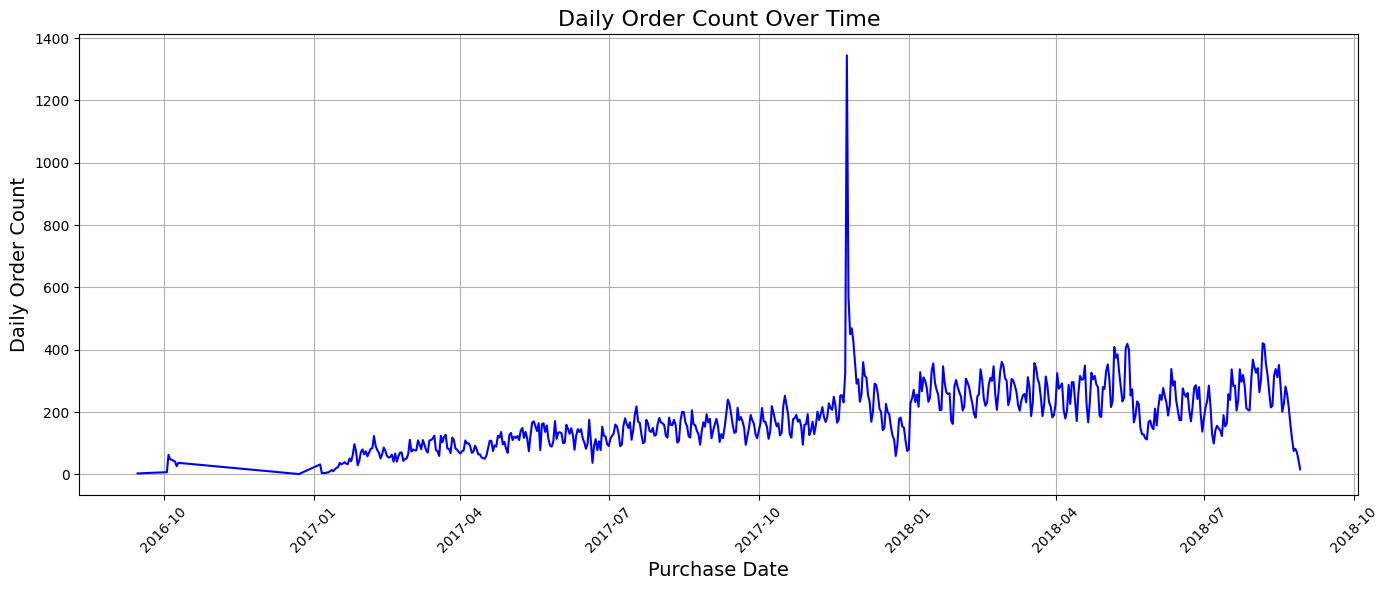

In [201]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(daily_order_count["purchase_date"], daily_order_count["daily_order_count"], color="blue")

plt.title("Daily Order Count Over Time", fontsize=16)
plt.xlabel("Purchase Date", fontsize=14)
plt.ylabel("Daily Order Count", fontsize=14)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [202]:
max_order_date = daily_order_count.loc[daily_order_count["daily_order_count"].idxmax(), "purchase_date"]

print(max_order_date)

2017-11-24


In [203]:
#final_clean = final_clean.drop('purchase_date', axis=1)

In [204]:
final_clean.head()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,purchase_weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,2,False,False,True,False,False,False,False,2017-09-13,226
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,2,False,False,True,False,False,False,False,2017-04-26,136
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,6,False,False,False,False,False,False,True,2018-01-14,246
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,2,False,False,True,False,False,False,False,2018-08-08,355
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,5,False,False,False,False,False,True,False,2017-02-04,70


In [205]:
final_clean

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,purchase_weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,2,False,False,True,False,False,False,False,2017-09-13,226
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,2,False,False,True,False,False,False,False,2017-04-26,136
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,6,False,False,False,False,False,False,True,2018-01-14,246
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,2,False,False,True,False,False,False,False,2018-08-08,355
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,5,False,False,False,False,False,True,False,2017-02-04,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110158,299.99,43.41,10150.0,2018-04-23 13:57:06,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,53400.0,2742.208890,17,...,0,True,False,False,False,False,False,False,2018-04-23,326
110159,350.00,36.53,8950.0,2018-07-14 10:26:46,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,44460.0,349.503925,9,...,5,False,False,False,False,False,True,False,2018-07-14,154
110160,99.90,16.95,967.0,2017-10-23 17:07:56,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,9576.0,339.118843,4,...,0,True,False,False,False,False,False,False,2017-10-23,180
110161,55.99,8.72,100.0,2017-08-14 23:02:59,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,8000.0,72.383986,1,...,0,True,False,False,False,False,False,False,2017-08-14,173


In [206]:
final_clean.columns

Index(['price', 'freight_value', 'product_weight_g',
       'order_purchase_timestamp', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'product_volume_cm3', 'distance_km', 'shipping_days', 'state_equal',
       'dif_days', 'shipping_cost_per_km', 'category_name_average',
       'purchase_weekday', 'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3',
       'weekday_4', 'weekday_5', 'weekday_6', 'purchase_date',
       'daily_order_count'],
      dtype='object')

In [207]:
final_clean.shape

(110163, 24)

In [208]:
#예측 배송일, 배송완료일 냅두기

In [209]:
final_clean.head()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,purchase_weekday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,2,False,False,True,False,False,False,False,2017-09-13,226
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,2,False,False,True,False,False,False,False,2017-04-26,136
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,6,False,False,False,False,False,False,True,2018-01-14,246
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,2,False,False,True,False,False,False,False,2018-08-08,355
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,5,False,False,False,False,False,True,False,2017-02-04,70


In [210]:
final_clean.describe()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km,category_name_average,purchase_weekday,daily_order_count
count,110163.000000,110163.000000,110163.000000,110163,110163,110163,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000
mean,119.974968,19.949473,2089.839565,2018-01-02 03:13:10.449034496,2018-01-14 14:33:17.051859456,2018-01-25 22:29:31.912529920,15173.466881,595.740900,12.007389,0.361791,11.027777,4.383814,12.007389,2.745677,239.803428
min,0.850000,0.000000,2.000000,2016-09-15 12:16:38,2016-10-11 13:46:32,2016-10-04 00:00:00,168.000000,0.001000,0.000000,0.000000,-189.000000,0.000000,5.291667,0.000000,1.000000
25%,39.900000,13.080000,300.000000,2017-09-15 09:16:01,2017-09-26 20:33:15,2017-10-06 00:00:00,2850.000000,185.871915,6.000000,0.000000,6.000000,0.024455,11.515478,1.000000,159.000000
50%,74.900000,16.260000,700.000000,2018-01-21 10:16:55,2018-02-02 21:14:40,2018-02-16 00:00:00,6460.000000,432.671324,10.000000,0.000000,12.000000,0.040930,12.057699,3.000000,226.000000
75%,134.200000,21.150000,1800.000000,2018-05-05 15:29:52.500000,2018-05-15 20:09:52,2018-05-28 00:00:00,18144.000000,792.496444,15.000000,1.000000,16.000000,0.088729,12.404044,4.000000,294.000000
max,6735.000000,409.680000,40425.000000,2018-08-29 15:00:37,2018-10-17 13:22:46,2018-10-25 00:00:00,296208.000000,8652.068296,209.000000,1.000000,146.000000,68420.000000,20.386691,6.000000,1345.000000
std,182.240945,15.700228,3741.776022,NaN,NaN,NaN,23239.829162,586.774589,9.451657,0.480521,10.158258,366.500523,1.336217,1.963039,152.869404


In [211]:
# 소요일 계산 (일 단위)
final_clean['esti_days'] = (final_clean['order_estimated_delivery_date'] - final_clean['order_purchase_timestamp']).dt.days

In [212]:
final_clean.describe()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km,category_name_average,purchase_weekday,daily_order_count,esti_days
count,110163.000000,110163.000000,110163.000000,110163,110163,110163,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000
mean,119.974968,19.949473,2089.839565,2018-01-02 03:13:10.449034496,2018-01-14 14:33:17.051859456,2018-01-25 22:29:31.912529920,15173.466881,595.740900,12.007389,0.361791,11.027777,4.383814,12.007389,2.745677,239.803428,23.438423
min,0.850000,0.000000,2.000000,2016-09-15 12:16:38,2016-10-11 13:46:32,2016-10-04 00:00:00,168.000000,0.001000,0.000000,0.000000,-189.000000,0.000000,5.291667,0.000000,1.000000,2.000000
25%,39.900000,13.080000,300.000000,2017-09-15 09:16:01,2017-09-26 20:33:15,2017-10-06 00:00:00,2850.000000,185.871915,6.000000,0.000000,6.000000,0.024455,11.515478,1.000000,159.000000,18.000000
50%,74.900000,16.260000,700.000000,2018-01-21 10:16:55,2018-02-02 21:14:40,2018-02-16 00:00:00,6460.000000,432.671324,10.000000,0.000000,12.000000,0.040930,12.057699,3.000000,226.000000,23.000000
75%,134.200000,21.150000,1800.000000,2018-05-05 15:29:52.500000,2018-05-15 20:09:52,2018-05-28 00:00:00,18144.000000,792.496444,15.000000,1.000000,16.000000,0.088729,12.404044,4.000000,294.000000,28.000000
max,6735.000000,409.680000,40425.000000,2018-08-29 15:00:37,2018-10-17 13:22:46,2018-10-25 00:00:00,296208.000000,8652.068296,209.000000,1.000000,146.000000,68420.000000,20.386691,6.000000,1345.000000,155.000000
std,182.240945,15.700228,3741.776022,NaN,NaN,NaN,23239.829162,586.774589,9.451657,0.480521,10.158258,366.500523,1.336217,1.963039,152.869404,8.822297


In [213]:
# order_purchase_timestamp를 datetime으로 변환 (만약 아직 문자열이라면)
final_clean['order_purchase_timestamp'] = pd.to_datetime(final_clean['order_purchase_timestamp'])


# 17시 기준 (17시 이후면 1, 이전이면 0)
final_clean['after_17'] = (final_clean['order_purchase_timestamp'].dt.hour >= 17).astype(int)

# 확인
final_clean.head()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count,esti_days,after_17
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,False,True,False,False,False,False,2017-09-13,226,15,0
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,False,True,False,False,False,False,2017-04-26,136,18,0
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,False,False,False,False,False,True,2018-01-14,246,21,0
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,False,True,False,False,False,False,2018-08-08,355,11,0
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,False,False,False,False,True,False,2017-02-04,70,40,0


In [214]:
# df=final_clean.drop(columns=['order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date','dif_days'])
df=final_clean
df

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count,esti_days,after_17
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,False,True,False,False,False,False,2017-09-13,226,15,0
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,False,True,False,False,False,False,2017-04-26,136,18,0
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,False,False,False,False,False,True,2018-01-14,246,21,0
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,False,True,False,False,False,False,2018-08-08,355,11,0
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,False,False,False,False,True,False,2017-02-04,70,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110158,299.99,43.41,10150.0,2018-04-23 13:57:06,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,53400.0,2742.208890,17,...,False,False,False,False,False,False,2018-04-23,326,24,0
110159,350.00,36.53,8950.0,2018-07-14 10:26:46,2018-07-17 08:05:00,2018-07-23 20:31:55,2018-08-01,44460.0,349.503925,9,...,False,False,False,False,True,False,2018-07-14,154,17,0
110160,99.90,16.95,967.0,2017-10-23 17:07:56,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,9576.0,339.118843,4,...,False,False,False,False,False,False,2017-10-23,180,17,1
110161,55.99,8.72,100.0,2017-08-14 23:02:59,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,8000.0,72.383986,1,...,False,False,False,False,False,False,2017-08-14,173,10,1


In [215]:
df.describe()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km,category_name_average,purchase_weekday,daily_order_count,esti_days,after_17
count,110163.000000,110163.000000,110163.000000,110163,110163,110163,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000,110163.000000
mean,119.974968,19.949473,2089.839565,2018-01-02 03:13:10.449034496,2018-01-14 14:33:17.051859456,2018-01-25 22:29:31.912529920,15173.466881,595.740900,12.007389,0.361791,11.027777,4.383814,12.007389,2.745677,239.803428,23.438423,0.401496
min,0.850000,0.000000,2.000000,2016-09-15 12:16:38,2016-10-11 13:46:32,2016-10-04 00:00:00,168.000000,0.001000,0.000000,0.000000,-189.000000,0.000000,5.291667,0.000000,1.000000,2.000000,0.000000
25%,39.900000,13.080000,300.000000,2017-09-15 09:16:01,2017-09-26 20:33:15,2017-10-06 00:00:00,2850.000000,185.871915,6.000000,0.000000,6.000000,0.024455,11.515478,1.000000,159.000000,18.000000,0.000000
50%,74.900000,16.260000,700.000000,2018-01-21 10:16:55,2018-02-02 21:14:40,2018-02-16 00:00:00,6460.000000,432.671324,10.000000,0.000000,12.000000,0.040930,12.057699,3.000000,226.000000,23.000000,0.000000
75%,134.200000,21.150000,1800.000000,2018-05-05 15:29:52.500000,2018-05-15 20:09:52,2018-05-28 00:00:00,18144.000000,792.496444,15.000000,1.000000,16.000000,0.088729,12.404044,4.000000,294.000000,28.000000,1.000000
max,6735.000000,409.680000,40425.000000,2018-08-29 15:00:37,2018-10-17 13:22:46,2018-10-25 00:00:00,296208.000000,8652.068296,209.000000,1.000000,146.000000,68420.000000,20.386691,6.000000,1345.000000,155.000000,1.000000
std,182.240945,15.700228,3741.776022,NaN,NaN,NaN,23239.829162,586.774589,9.451657,0.480521,10.158258,366.500523,1.336217,1.963039,152.869404,8.822297,0.490203


In [216]:
# shipping_days 상위 3% 제거
upper_limit = df['shipping_days'].quantile(0.97)
df = df[df['shipping_days'] <= upper_limit]

# 2017-11-24 daily_order_count 데이터 제거
df = df[~((df['purchase_date'] == '2017-11-24') & df['daily_order_count'].notna())]

# shipping_cost_per_km, price, freight_value 상위 값 제거
upper_limit_shipping = df['shipping_cost_per_km'].quantile(0.98)
upper_limit_price = df['price'].quantile(0.95)
upper_limit_freight = df['freight_value'].quantile(0.99)

df = df[df['shipping_cost_per_km'] <= upper_limit_shipping]
df = df[df['price'] <= upper_limit_price]
df = df[df['freight_value'] <= upper_limit_freight]
df

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,...,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,purchase_date,daily_order_count,esti_days,after_17
0,58.90,13.29,650.0,2017-09-13 08:59:02,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,3528.0,301.582449,7,...,False,True,False,False,False,False,2017-09-13,226,15,0
1,239.90,19.93,30000.0,2017-04-26 10:53:06,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,60000.0,587.970634,16,...,False,True,False,False,False,False,2017-04-26,136,18,0
2,199.00,17.87,3050.0,2018-01-14 14:33:31,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,14157.0,311.990753,7,...,False,False,False,False,False,True,2018-01-14,246,21,0
3,12.99,12.79,200.0,2018-08-08 10:00:35,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,2400.0,293.925230,6,...,False,True,False,False,False,False,2018-08-08,355,11,0
4,199.90,18.14,3750.0,2017-02-04 13:57:51,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17,42000.0,647.515365,25,...,False,False,False,False,True,False,2017-02-04,70,40,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110157,119.85,20.03,1050.0,2018-06-19 09:27:48,2018-06-29 13:46:00,2018-07-05 17:51:08,2018-07-23,5120.0,799.965912,16,...,True,False,False,False,False,False,2018-06-19,258,33,0
110158,299.99,43.41,10150.0,2018-04-23 13:57:06,2018-04-25 12:09:00,2018-05-10 22:56:40,2018-05-18,53400.0,2742.208890,17,...,False,False,False,False,False,False,2018-04-23,326,24,0
110160,99.90,16.95,967.0,2017-10-23 17:07:56,2017-10-26 15:13:14,2017-10-28 12:22:22,2017-11-10,9576.0,339.118843,4,...,False,False,False,False,False,False,2017-10-23,180,17,1
110161,55.99,8.72,100.0,2017-08-14 23:02:59,2017-08-15 19:02:53,2017-08-16 21:59:40,2017-08-25,8000.0,72.383986,1,...,False,False,False,False,False,False,2017-08-14,173,10,1


In [217]:
df.shape

(99236, 26)

In [218]:
df.describe()

,price,freight_value,product_weight_g,order_purchase_timestamp,order_delivered_customer_date,order_estimated_delivery_date,product_volume_cm3,distance_km,shipping_days,state_equal,dif_days,shipping_cost_per_km,category_name_average,purchase_weekday,daily_order_count,esti_days,after_17
count,99236.000000,99236.000000,99236.000000,99236,99236,99236,99236.000000,99236.000000,99236.00000,99236.000000,99236.000000,99236.000000,99236.000000,99236.000000,99236.000000,99236.000000,99236.000000
mean,88.195311,18.181943,1746.554627,2018-01-01 23:31:08.199423488,2018-01-13 10:52:43.019891968,2018-01-25 14:57:49.837558784,13194.727790,580.580958,11.00785,0.365261,11.868133,0.103601,11.991228,2.746141,238.848775,23.278790,0.401649
min,0.850000,0.000000,2.000000,2016-10-03 09:44:50,2016-10-11 13:46:32,2016-10-27 00:00:00,168.000000,1.525668,0.00000,0.000000,-25.000000,0.000000,5.291667,0.000000,1.000000,2.000000,0.000000
25%,38.950000,12.840000,267.000000,2017-09-13 13:27:07.500000,2017-09-25 15:56:19,2017-10-04 00:00:00,2800.000000,193.698437,6.00000,0.000000,7.000000,0.024153,11.515478,1.000000,159.000000,18.000000,0.000000
50%,69.900000,16.050000,625.000000,2018-01-19 20:32:27.500000,2018-02-01 11:02:32.500000,2018-02-15 00:00:00,6000.000000,428.167414,10.00000,0.000000,12.000000,0.040074,12.191736,3.000000,226.000000,23.000000,0.000000
75%,119.900000,19.800000,1650.000000,2018-05-06 22:09:34.750000128,2018-05-16 00:15:13.500000,2018-05-28 00:00:00,16038.000000,770.930791,14.00000,1.000000,16.000000,0.081481,12.404044,4.000000,292.000000,28.000000,1.000000
max,343.400000,82.860000,40425.000000,2018-08-29 15:00:37,2018-09-13 19:24:35,2018-10-23 00:00:00,274625.000000,8652.068296,34.00000,1.000000,146.000000,1.307874,20.386691,6.000000,1345.000000,155.000000,1.000000
std,66.427679,10.086476,2959.456200,NaN,NaN,NaN,18009.268407,563.559145,6.68833,0.481506,8.271603,0.181880,1.288350,1.963579,151.656057,8.607654,0.490234


In [219]:
#from google.colab import files
#df.to_csv("realrealfinal.csv", index=False)
#files.download("realrealfinal.csv")

## **전처리 완료**

In [220]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [221]:
data = pd.read_csv("realrealfinal.csv")
df = pd.DataFrame(data)
X = df[['freight_value', 'product_volume_cm3', 'price', 'after_17',
        'distance_km','shipping_cost_per_km', 'category_name_average', 'daily_order_count',
        'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'product_weight_g']]
y = df['shipping_days']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [222]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

In [223]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 4.420009640758387
RMSE: 5.80122380809045
R^2: 0.2421143277676846


In [224]:
coef_df = pd.DataFrame({
    "feature": X.columns,
    "coefficient": model.coef_
})
print(coef_df)

                  feature  coefficient
0           freight_value     0.264420
1      product_volume_cm3     0.193304
2                   price     0.030964
3                after_17    -0.052804
4             distance_km     2.465159
5    shipping_cost_per_km    -0.966668
6   category_name_average     0.879556
7       daily_order_count     0.403257
8               weekday_0    -0.228533
9               weekday_1    -0.138745
10              weekday_2    -0.055350
11              weekday_3     0.101128
12              weekday_4     0.280341
13              weekday_5     0.212327
14              weekday_6    -0.134247
15       product_weight_g     0.226560


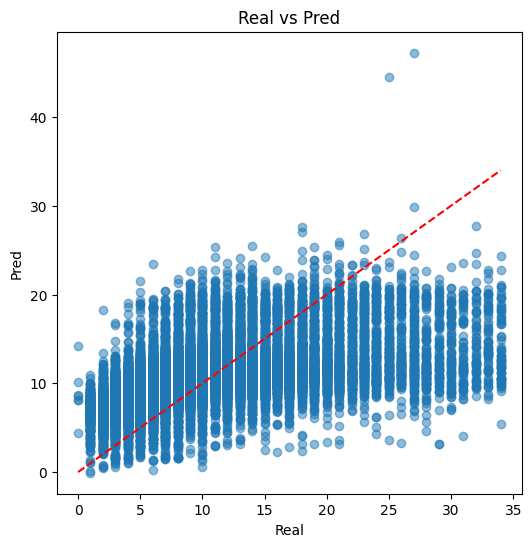

In [225]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Real")
plt.ylabel("Pred")
plt.title("Real vs Pred")
plt.show()

## **랜덤포레스트**

In [226]:
upper_limit = df['shipping_days'].quantile(0.98)  # 상위 2% 제외
df['shipping_days'] = df['shipping_days'].clip(upper=upper_limit)

df = df[~((df['purchase_date'] == '2017-11-24') & df['daily_order_count'].notna())]

upper_limit_shipping = df['shipping_cost_per_km'].quantile(0.99)
upper_limit_price = df['price'].quantile(0.99)
upper_limit_freight = df['freight_value'].quantile(0.99)

df['shipping_cost_per_km'] = df['shipping_cost_per_km'].clip(upper=upper_limit_shipping)
df['price'] = df['price'].clip(upper=upper_limit_price)
df['freight_value'] = df['freight_value'].clip(upper=upper_limit_freight)

X = df[['price', 'freight_value', 'product_volume_cm3',
        'distance_km','shipping_cost_per_km', 'category_name_average', 'daily_order_count',
        'weekday_0', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'product_weight_g']]
y = df['shipping_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df[['price','freight_value','shipping_cost_per_km']].describe()

,price,freight_value,shipping_cost_per_km
count,98053.000000,98053.000000,98053.000000
mean,88.011588,18.105434,0.102164
std,65.559789,9.686112,0.173565
min,0.850000,0.000000,0.000000
25%,38.990000,12.840000,0.024177
50%,69.900000,16.050000,0.040106
75%,119.900000,19.820000,0.081552
max,300.000000,60.209600,0.977729


In [227]:
rf_model = RandomForestRegressor(
    n_estimators=200,  # 트리 개수
    max_depth=None,    # 트리 깊이 제한 없음
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=-1, random_state=42)

In [228]:
y_pred = rf_model.predict(X_test)

In [230]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 3.6206278448157945
RMSE: 4.951973904648233
R^2: 0.4226011584077535


In [231]:
feat_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(feat_importance)

                  feature  importance
3             distance_km    0.338823
6       daily_order_count    0.109476
1           freight_value    0.094067
0                   price    0.091322
2      product_volume_cm3    0.085204
4    shipping_cost_per_km    0.082166
14       product_weight_g    0.075016
5   category_name_average    0.068072
8               weekday_1    0.008635
9               weekday_2    0.008504
10              weekday_3    0.008402
7               weekday_0    0.008349
11              weekday_4    0.007700
13              weekday_6    0.007463
12              weekday_5    0.006800


## **LightGBM**

In [232]:
lgb_model = lgb.LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    num_leaves=250,
    n_estimators=1000,
    random_state=42
)

In [233]:
lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005772 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1838
[LightGBM] [Info] Number of data points in the train set: 78442, number of used features: 15
[LightGBM] [Info] Start training from score 10.923268


LGBMRegressor(n_estimators=1000, num_leaves=250, objective='regression',
              random_state=42)

In [234]:
y_pred = lgb_model.predict(X_test)

In [235]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 3.474174765023354
RMSE: 4.863011256869835
R^2: 0.44316084835823166


                  feature  importance  importance_ratio
6       daily_order_count       41330          0.165984
0                   price       33025          0.132631
3             distance_km       31145          0.125080
2      product_volume_cm3       30520          0.122570
4    shipping_cost_per_km       29974          0.120378
1           freight_value       28382          0.113984
14       product_weight_g       26583          0.106759
5   category_name_average       17627          0.070791
8               weekday_1        1905          0.007651
7               weekday_0        1802          0.007237
9               weekday_2        1783          0.007161
10              weekday_3        1434          0.005759
12              weekday_5        1203          0.004831
13              weekday_6        1186          0.004763
11              weekday_4        1101          0.004422


/tmp/ipython-input-3464034089.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_ratio', y='feature', data=importance, palette='viridis')


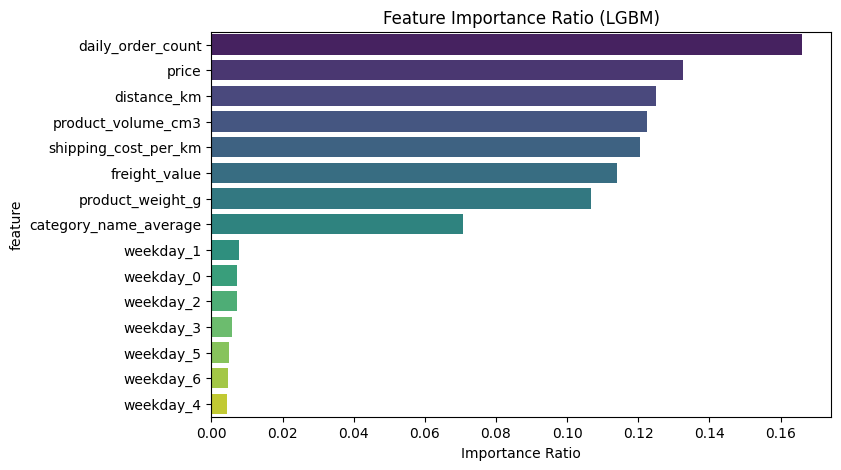

In [236]:
# feature importance 비율 계산
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
})

# 비율로 변환
importance['importance_ratio'] = importance['importance'] / importance['importance'].sum()

# 중요도 기준 정렬
importance = importance.sort_values(by='importance_ratio', ascending=False)

print(importance)

# 시각화
plt.figure(figsize=(8,5))
sns.barplot(x='importance_ratio', y='feature', data=importance, palette='viridis')
plt.title("Feature Importance Ratio (LGBM)")
plt.xlabel("Importance Ratio")
plt.show()


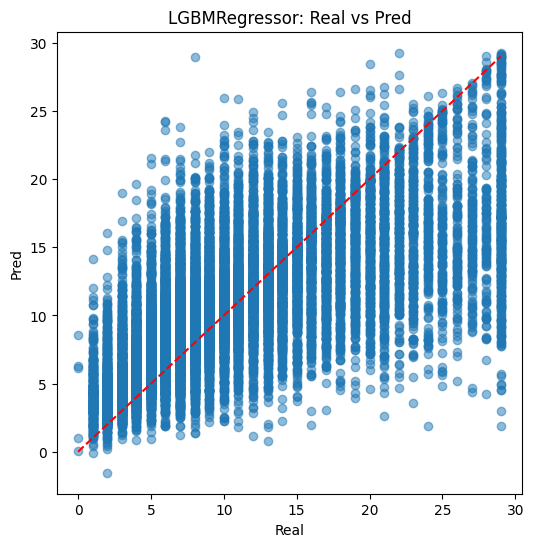

In [237]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         'r--')
plt.xlabel("Real")
plt.ylabel("Pred")
plt.title("LGBMRegressor: Real vs Pred")
plt.show()

## **XGBoost**

In [239]:
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    n_estimators=1000,
    max_depth=12,
    subsample=0.9,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric='rmse'  # 회귀용 평가지표로 변경
)

In [240]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=50
)

[0]	validation_0-rmse:6.31400
[50]	validation_0-rmse:4.98588
[100]	validation_0-rmse:4.87934
[150]	validation_0-rmse:4.84551
[200]	validation_0-rmse:4.82698
[250]	validation_0-rmse:4.81925
[300]	validation_0-rmse:4.81791
[350]	validation_0-rmse:4.81722
[400]	validation_0-rmse:4.81755
[450]	validation_0-rmse:4.81922
[500]	validation_0-rmse:4.82168
[550]	validation_0-rmse:4.82369
[600]	validation_0-rmse:4.82449
[650]	validation_0-rmse:4.82660
[700]	validation_0-rmse:4.82830
[750]	validation_0-rmse:4.82953
[800]	validation_0-rmse:4.83072
[850]	validation_0-rmse:4.83131
[900]	validation_0-rmse:4.83181
[950]	validation_0-rmse:4.83268
[999]	validation_0-rmse:4.83324


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='rmse', feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=12,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=-1, num_parallel_tree=None, ...)

In [241]:
y_pred = xgb_model.predict(X_test)

In [243]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R^2: {r2}")

MAE: 3.3591394424438477
RMSE: 4.833238776148013
R^2: 0.4499582052230835


                  feature  importance
3             distance_km    0.156854
5   category_name_average    0.082528
6       daily_order_count    0.071503
1           freight_value    0.069525
14       product_weight_g    0.066803
12              weekday_5    0.061511
4    shipping_cost_per_km    0.061272
7               weekday_0    0.059090
2      product_volume_cm3    0.058689
10              weekday_3    0.057525
13              weekday_6    0.056549
9               weekday_2    0.055948
8               weekday_1    0.053268
11              weekday_4    0.049715
0                   price    0.039221


/tmp/ipython-input-2806751823.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance, palette='viridis')


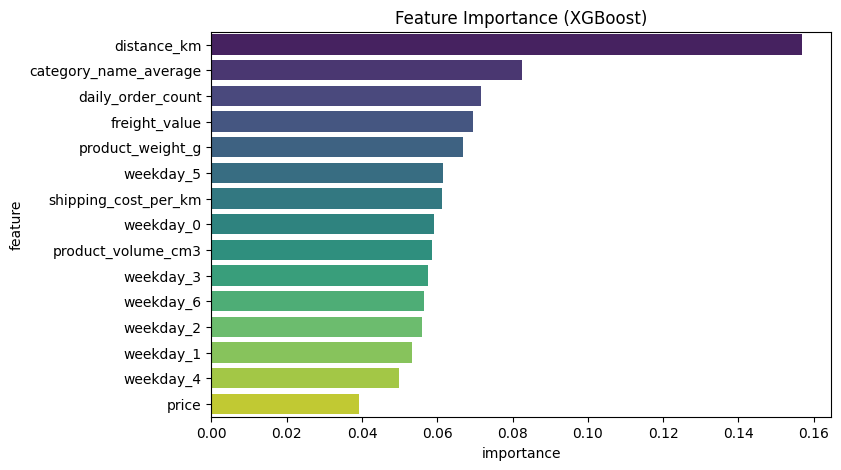

In [244]:
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values(by='importance', ascending=False)

print(importance)

plt.figure(figsize=(8,5))
sns.barplot(x='importance', y='feature', data=importance, palette='viridis')
plt.title("Feature Importance (XGBoost)")
plt.show()

## **시각화**

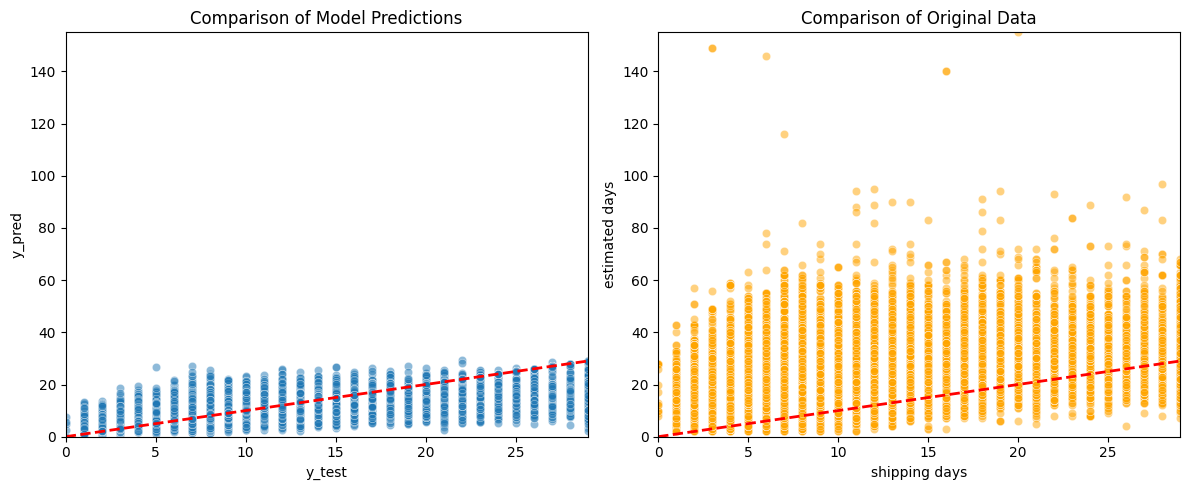

In [245]:
plt.figure(figsize=(12, 5))

# x축 범위
x_min = min(y_test.min(), df['shipping_days'].min())
x_max = max(y_test.max(), df['shipping_days'].max())

# y축 범위
y_min = min(y_pred.min(), df['esti_days'].min())
y_max = max(y_pred.max(), df['esti_days'].max())

# 1. y_test vs y_pred 산점도
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # y=x 선
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.title("Comparison of Model Predictions")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

# 2. df['shipping_days'] vs df['esti_days'] 산점도
plt.subplot(1, 2, 2)
sns.scatterplot(x=df['shipping_days'], y=df['esti_days'], alpha=0.5,color='orange')
plt.plot([df['shipping_days'].min(), df['shipping_days'].max()],
         [df['shipping_days'].min(), df['shipping_days'].max()],
         'r--', lw=2)  # y=x 선
plt.xlabel("shipping days")
plt.ylabel("estimated days")
plt.title("Comparison of Original Data")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)

plt.tight_layout()
plt.show()



Model vs Actual:
MAE: 3.3591, RMSE: 4.8332
Dataset Estimate vs Actual:
MAE: 12.7357, RMSE: 14.7825


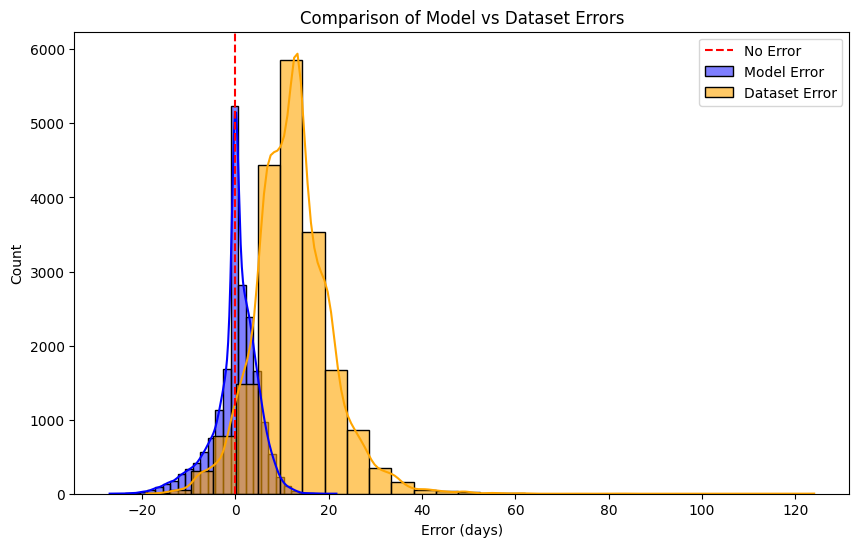

In [246]:
# X_test 인덱스를 이용해서 데이터셋 예상 배송일 가져오기
dataset_pred = df.loc[X_test.index, 'esti_days']

# MAE / RMSE 계산
mae_model = mean_absolute_error(y_test, y_pred)
rmse_model = mean_squared_error(y_test, y_pred)**0.5

mae_dataset = mean_absolute_error(y_test, dataset_pred)
rmse_dataset = mean_squared_error(y_test, dataset_pred)**0.5

print("Model vs Actual:")
print(f"MAE: {mae_model:.4f}, RMSE: {rmse_model:.4f}")
print("Dataset Estimate vs Actual:")
print(f"MAE: {mae_dataset:.4f}, RMSE: {rmse_dataset:.4f}")

# 오차 히스토그램

plt.figure(figsize=(10,6))
sns.histplot(y_pred - y_test, bins=30, color='blue', label='Model Error',kde=True)
sns.histplot(dataset_pred - y_test, bins=30, color='orange', label='Dataset Error', kde=True, alpha=0.6)
plt.axvline(0, color='red', linestyle='--', label='No Error')
plt.title('Comparison of Model vs Dataset Errors')
plt.xlabel('Error (days)')
plt.ylabel('Count')
plt.legend()
plt.show()